In [1]:
#!pip install opencv-python==4.6.0.66

In [2]:
#!pip install torch-summary

In [3]:
import os
import math
import cv2
import tarfile
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm as CM

In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [5]:
import h5py
import json
import scipy
import scipy.io as io
from scipy.spatial import KDTree
from scipy.ndimage.filters import gaussian_filter

In [6]:
#from imutils import paths
from sklearn.model_selection import train_test_split


from torch.optim import Adam
from torchsummary import summary
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Normalize, Compose, CenterCrop

In [7]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True, dtype=torch.float)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
device = get_default_device()
print(device)

cuda


In [10]:
list(range(torch.cuda.device_count()))

[0, 1, 2, 3]

In [11]:
torch.cuda.device_count()

4

In [12]:
#torch.cuda.current_device()

In [13]:
#torch.cuda.device(1)

In [14]:
#torch.cuda.get_device_name(1)

In [15]:
#torch.cuda.current_device()

In [16]:
# To determine if we will be pinning memory during data loading
pin_memory = True if device.type == "cuda" else False
pin_memory

True

In [17]:
def relu():
    return nn.ReLU()

def batch_norm(ni):
    return nn.BatchNorm2d(ni)

def conv_2d(ni, nf, ks=3, stride=1, dilation=1):
    return nn.Conv2d(in_channels=ni, out_channels=nf, kernel_size=ks, stride=stride, padding=(ks//2) * dilation, dilation=dilation, bias=True)

def upsample(size, scale_factor=8):
    return nn.UpsamplingBilinear2d(size=size)

In [18]:
class CSRNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        dim = [3, 64, 128, 256, 512]
        
         
        #Layer: conv0, Output: [batch_size, 64, w, h]
        self.conv0 = nn.Sequential(
                    conv_2d(dim[0], dim[1]),
                    relu())
        
        #Layer: conv1, Output: [batch_size, 64, w, h]
        self.conv1 = nn.Sequential(
                    conv_2d(dim[1], dim[1]),
                    relu())
        
        #Layer: conv2, Output: [batch_size, 128, w/2, h/2]
        self.conv2 = nn.Sequential(
                    conv_2d(dim[1], dim[2]),
                    relu())
        
        #Layer: conv3, Output: [batch_size, 128, w/2, h/2]
        self.conv3 = nn.Sequential(
                    conv_2d(dim[2], dim[2]),
                    relu())
        
        #Layer: conv4, Output: [batch_size, 256, w/4, h/4]
        self.conv4 = nn.Sequential(
                    conv_2d(dim[2], dim[3]),
                    relu())
        
        #Layer: conv5, Output: [batch_size, 256, w/4, h/4]
        self.conv5 = nn.Sequential(
                    conv_2d(dim[3], dim[3]),
                    relu())
        
        #Layer: conv6, Output: [batch_size, 256, w/4, h/4]
        self.conv6 = nn.Sequential(
                    conv_2d(dim[3], dim[3]),
                    relu())
        
        #Layer: conv7, Output: [batch_size, 512, w/8, h/8]
        self.conv7 = nn.Sequential(
                    conv_2d(dim[3], dim[4]),
                    relu())
        
        #Layer: conv8, Output: [batch_size, 512, w/8, h/8]
        self.conv8 = nn.Sequential(
                    conv_2d(dim[4], dim[4]),
                    relu())
        
        #Layer: conv9, Output: [batch_size, 512, w/8, h/8]
        self.conv9 = nn.Sequential(
                    conv_2d(dim[4], dim[4]),
                    relu())
        
        #Layer: conv10, Output: [batch_size, 512, w/8, h/8]
        self.conv10 = nn.Sequential(
                    conv_2d(dim[4], dim[4], dilation=2),
                    relu())
        
        #Layer: conv11, Output: [batch_size, 512, w/8, h/8]
        self.conv11 = nn.Sequential(
                    conv_2d(dim[4], dim[4], dilation=2),
                    relu())
        
        #Layer: conv12, Output: [batch_size, 512, w/8, h/8]
        self.conv12 = nn.Sequential(
                    conv_2d(dim[4], dim[4], dilation=2),
                    relu())
        
        #Layer: conv13, Output: [batch_size, 256, w/8, h/8]
        self.conv13 = nn.Sequential(
                    conv_2d(dim[4], dim[3], dilation=2),
                    relu())
        
        #Layer: conv14, Output: [batch_size, 128, w/8, h/8]
        self.conv14 = nn.Sequential(
                    conv_2d(dim[3], dim[2], dilation=2),
                    relu())
        
        #Layer: conv15, Output: [batch_size, 64, w/8, h/8]
        self.conv15 = nn.Sequential(
                    conv_2d(dim[2], dim[1], dilation=2),
                    relu())
        
        #Layer: conv16, Output: [batch_size, 1, w/8, h/8]
        self.conv16 = conv_2d(dim[1], 1, ks=1)


        self.maxpool = nn.MaxPool2d(2, stride=2)

        #self.scale = nn.UpsamplingBilinear2d(scale_factor=8)

        
    def forward(self, x):
        _, _, h, w = x.shape
        
        conv0 = self.conv0(x)      #Output: [batch_size, 64, w, h]
        conv1 = self.conv1(conv0)  #Output: [batch_size, 64, w, h]
        mp1 = self.maxpool(conv1)  #Output: [batch_size, 64, w/2, h/2]

        conv2 = self.conv2(mp1)    #Output: [batch_size, 128, w/2, h/2]
        conv3 = self.conv3(conv2)  #Output: [batch_size, 128, w/2, h/2]
        mp2 = self.maxpool(conv3)  #Output: [batch_size, 128, w/4, h/4]

        conv4 = self.conv4(mp2)    #Output: [batch_size, 256, w/4, h/4]
        conv5 = self.conv5(conv4)  #Output: [batch_size, 256, w/4, h/4]
        conv6 = self.conv6(conv5)  #Output: [batch_size, 256, w/4, h/4]
        mp3 = self.maxpool(conv6)  #Output: [batch_size, 256, w/8, h/8]

        conv7 = self.conv7(mp3)    #Output: [batch_size, 512, w/8, h/8]
        conv8 = self.conv8(conv7)  #Output: [batch_size, 512, w/8, h/8]
        conv9 = self.conv9(conv8)  #Output: [batch_size, 512, w/8, h/8]

        conv10 = self.conv10(conv9)   #Output: [batch_size, 512, w/8, h/8]
        conv11 = self.conv11(conv10)  #Output: [batch_size, 512, w/8, h/8]
        conv12 = self.conv12(conv11)  #Output: [batch_size, 512, w/8, h/8]

        conv13 = self.conv13(conv12)  #Output: [batch_size, 256, w/8, h/8]
        conv14 = self.conv14(conv13)  #Output: [batch_size, 128, w/8, h/8]
        conv15 = self.conv15(conv14)  #Output: [batch_size, 64, w/8, h/8]
        conv16 = self.conv16(conv15)  #Output: [batch_size, 1, w/8, h/8]
        

        #scale = self.scale(conv16)    #Output: [batch_size, 1, w, h]
        up = upsample((h,w))
        scale = up(conv16)

        return scale

In [19]:
model = CSRNet()
#model.to("cuda")
#model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])

to_device(model, device)

CSRNet(
  (conv0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv5): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv6): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv7): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv8): Sequential(
    (0): Conv2d

In [20]:
from torchsummary import summary

summary(model, input_size=(3, 1024, 768))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-3                       36,928
|    └─ReLU: 2-4                         --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-5                       73,856
|    └─ReLU: 2-6                         --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-7                       147,584
|    └─ReLU: 2-8                         --
├─Sequential: 1-5                        --
|    └─Conv2d: 2-9                       295,168
|    └─ReLU: 2-10                        --
├─Sequential: 1-6                        --
|    └─Conv2d: 2-11                      590,080
|    └─ReLU: 2-12                        --
├─Sequential: 1-7                        --
|    └─Conv2d: 2-13                      590,080
|    └─ReLU: 2-14                       

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-3                       36,928
|    └─ReLU: 2-4                         --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-5                       73,856
|    └─ReLU: 2-6                         --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-7                       147,584
|    └─ReLU: 2-8                         --
├─Sequential: 1-5                        --
|    └─Conv2d: 2-9                       295,168
|    └─ReLU: 2-10                        --
├─Sequential: 1-6                        --
|    └─Conv2d: 2-11                      590,080
|    └─ReLU: 2-12                        --
├─Sequential: 1-7                        --
|    └─Conv2d: 2-13                      590,080
|    └─ReLU: 2-14                       

In [21]:
input1 = torch.randn(1, 3, 111, 55)

In [22]:
input1 = input1.cuda()

In [23]:
output1 = model(input1)

# a, b, c, d, e, f, g, h, i, j = output1
# print(a.shape, b.shape, c.shape, d.shape, e.shape, f.shape, g.shape, h.shape, i.shape, j.shape)

a = output1
print(a.shape)

torch.Size([1, 1, 111, 55])


------------Test--------

In [24]:
# mm = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=2, dilation=2, bias=False)

In [25]:
# in1 = torch.randn(2, 512, 32, 32)
# out = mm(in1)
# print(out.shape)

In [26]:
# #mn = F.interpolate(input, size=None, scale_factor=None, mode='nearest', align_corners=None, recompute_scale_factor=None, antialias=False)
# mn = nn.UpsamplingBilinear2d(scale_factor=1)
# out = mn(in1)
# out.shape

------------Test--------

### Dataset Preparation - ShanghaiTech

In [27]:
#dataset = 'Dataset_Crowd_Counting\\Shanghai_Tech\\ShanghaiTech' #For Windows
dataset = 'Dataset_Crowd_Counting/Shanghai_Tech/ShanghaiTech' #For Linux

_partA = 'part_A'
_partB = 'part_B'
_train_path = 'train_data'
_test_path = 'test_data'
_images = 'images'
_targets = 'ground-truth'

#root = 'C:/Users/subir/Downloads/GNR-Project/'

In [28]:
root = os.path.join(os.getcwd(), dataset)
partA_train_data = os.path.join(root, _partA, _train_path, _images)
partA_train_target = os.path.join(root, _partA, _train_path, _targets)
partA_test_data = os.path.join(root, _partA, _test_path, _images)
partA_test_target = os.path.join(root, _partA, _test_path, _targets)

partB_train_data = os.path.join(root, _partB, _train_path, _images)
partB_train_target = os.path.join(root, _partB, _train_path, _targets)
partB_test_data = os.path.join(root, _partB, _test_path, _images)
partB_test_target = os.path.join(root, _partB, _test_path, _targets)

In [29]:
partA_test_target

'/home/development/nihars/subir/wd/Dataset_Crowd_Counting/Shanghai_Tech/ShanghaiTech/part_A/test_data/ground-truth'

In [30]:
def list_images(data_path):
    
    #List to hold all training/testing images filenames
    image_list = []
    
    #Iterating over the training/testing images to fetch all filenames and appending it to the filenames list
    for img_path in os.listdir(data_path):
        image_list.append(img_path)
        
    return image_list

In [31]:
train_image_list_A = list_images(partA_train_data)

#Display the length of the list of all training images filename
print(len(train_image_list_A))

#Display the list of one such training image filename
print(train_image_list_A[10])

300
IMG_41.jpg


In [32]:
test_image_list_A = list_images(partA_test_data)

#Display the length of the list of all testing images filename
print(len(test_image_list_A))

#Display the list of one such testing image filename
print(test_image_list_A[10])

182
IMG_89.jpg


In [33]:
train_image_list_B = list_images(partB_train_data)

#Display the length of the list of all training images filename
print(len(train_image_list_B))

#Display the list of one such training image filename
print(train_image_list_B[10])

400
IMG_42.jpg


In [34]:
test_image_list_B = list_images(partB_test_data)

#Display the length of the list of all testing images filename
print(len(test_image_list_B))

#Display the list of one such testing image filename
print(test_image_list_B[10])

316
IMG_41.jpg


In [35]:
#This code is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet

def gaussian_filter_density(gt):
    
    #print(gt.shape)
    density_map = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    
    if gt_count == 0:
        return density_map

    leafsize = 2048
    
    gt_1 = np.nonzero(gt)[1]
    gt_0 = np.nonzero(gt)[0]
    heads = np.stack((gt_1, gt_0), axis=1)

    # build kdtree
    tree = KDTree(heads, leafsize=leafsize)
    
    # query kdtree
    distances, locations = tree.query(heads, k=4)

    for i, hd in enumerate(heads):
        hd2d = np.zeros(gt.shape, dtype=np.float32)
        hd2d[hd[1], hd[0]] = 1
        if gt_count > 1:
            sigma = (distances[i][1] + distances[i][2] + distances[i][3]) * 0.1
        else:
            sigma = np.average(np.array(gt.shape))/4
        density_map += gaussian_filter(hd2d, sigma, mode='constant')
    
    return density_map

In [36]:
def create_density_map(image_list, data_path, target_path):
    count = 0
    
    for _path in image_list:
        str1 = 'GT_' + _path
        str1 = str1.replace('.jpg', '.mat')
        img_path = os.path.join(data_path, _path)
        gt_path = os.path.join(target_path, str1)
        h5_path = gt_path.replace('ShanghaiTech', 'DensityMaps')
        str2 = h5_path.replace('.mat', '.h5')
        
        #print(str2)
        #print(img_path)
        #print(gt_path)
        #print(h5_path)
        #print("----------------")
        
    
        img = cv2.imread(img_path, cv2.IMREAD_COLOR) #Load and read the image using cv2 as BGR format
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Converting the image into RGB
    

        plt.rcParams["figure.figsize"] = (15, 10) #Setting the size of the plot
    
        plt.subplot(1, 2, 1)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title('Image')
    
    
        r, c, ch = img_rgb.shape
        #print(r, c)

        heads = np.zeros((r, c))
    
        mat = io.loadmat(gt_path)
        gt = mat["image_info"][0][0][0][0][0]
        gt = gt.astype(int)
        #print(gt)
    
        for i in range(len(gt)):
            heads[gt[i][1], gt[i][0]] = 1
    
        density = gaussian_filter_density(heads)
        #print(density.shape)
        
        with h5py.File(str2, 'w') as hf:
            hf['density_map'] = density
        
        gt_file = h5py.File(str2, 'r')
        groundtruth = np.asarray(gt_file['density_map'])
        print(count, np.sum(groundtruth))
        count+=1
    
        plt.subplot(1, 2, 2)
        plt.imshow(groundtruth, cmap=CM.jet)
        plt.axis('off')
        plt.title('Density Map')
        
    
        plt.show()
        
        #-----
        #str3 = str1.replace('.mat', '.jpg')
        #filename = os.path.join(target_path, str3)
        #cv2.imwrite(filename, groundtruth)
        
        #cmap = plt.cm.jet
        #image = cmap(groundtruth)
        # save the image
        #plt.imsave(filename, image)
    
        gt_file.close()
        #return density
        break

0 335.9118


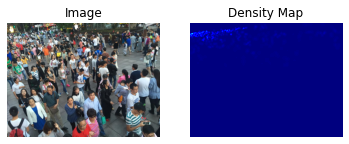

In [37]:
create_density_map(train_image_list_B, partB_train_data, partB_train_target)

0 52.823143


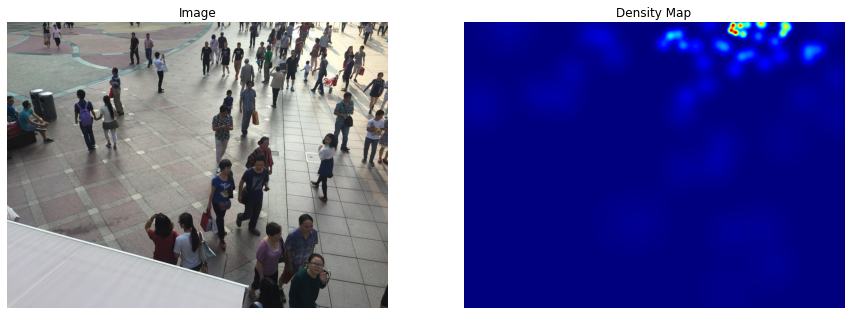

In [38]:
create_density_map(test_image_list_B, partB_test_data, partB_test_target)

In [39]:
#create_density_map(train_image_list_A, partA_train_data, partA_train_target)

In [40]:
#create_density_map(test_image_list_A, partA_test_data, partA_test_target)

In [41]:
#partA_test_target

In [42]:
# _path = 'IMG_125.jpg'
# data_path = 'C:\\Users\\subir\\Downloads\\GNR-Project\\Dataset_Crowd_Counting\\Shanghai_Tech\\ShanghaiTech\\part_A\\test_data\\images'
# target_path = 'C:\\Users\\subir\\Downloads\\GNR-Project\\Dataset_Crowd_Counting\\Shanghai_Tech\\ShanghaiTech\\part_A\\test_data\\ground-truth'

In [43]:
# img_path = os.path.join(data_path, _path)

# str1 = 'GT_' + _path
# str1 = str1.replace('.jpg', '.h5')
# gt_path = os.path.join(target_path, str1)
# h5_path = gt_path.replace('ShanghaiTech', 'DensityMaps')
# print(h5_path)

In [44]:
# img_path

In [45]:
# img = cv2.imread(img_path, cv2.IMREAD_COLOR) #Load and read the image using cv2 as BGR format
# img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Converting the image into RGB

# plt.imshow(img_rgb)
# plt.axis('off')

# plt.show()

In [46]:
# gt_file = h5py.File(h5_path, 'r')
# groundtruth = np.asarray(gt_file['density_map'])

# plt.imshow(groundtruth, cmap=CM.jet)
# plt.axis('off')
# plt.title('Density Map')

# plt.show()

In [47]:
# print(img_rgb.shape)
# print(groundtruth.shape)

In [48]:
#Class definition for data and labels extraction and pre-processing
class Dataset_Preparation(Dataset):
    def __init__(self, imagePaths, densityPaths, transforms, t2):
        self.imagePaths = imagePaths #store the image filepath
        self.densityPaths = densityPaths #store the density filepath
        self.transforms = transforms #store the augmentation transforms
        self.t2 = t2
        
    def __len__(self):
        return len(self.imagePaths) #return the number of samples in the dataset
    
    def __getitem__(self, idx):
        imagePath = self.imagePaths[idx] #Obtain the image from the imagepath using the current index
        densityPath = self.densityPaths[idx] #Obtain the density map of the image from the densityPaths using the current index
        
        image = cv2.imread(imagePath) #Load and read the image from disk in BGR format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #Converting BGR to RGB format
        image = image / 255
        
        gt = h5py.File(densityPath, 'r')
        density = np.asarray(gt['density_map'])
        
        
        if self.transforms is not None:
            image = self.transforms(image) #Apply the specified transform on the image
        density = self.t2(density)
              
        #return a tuple of the image and its mask
        return (image, density)

In [49]:
#train_image_list_B, partB_train_data, partB_train_target
#test_image_list_B, partB_test_data, partB_test_target

_trainImages = partA_train_data
_trainTargets = partA_train_target

_testImages = partA_test_data
_testTargets = partA_test_target

In [50]:
def prepare_list(image_filenames, image_path, target_path):
    images = []
    targets = []
    
    for _path in image_filenames:
        img_path = os.path.join(image_path, _path)
        
        str1 = 'GT_' + _path
        str1 = str1.replace('.jpg', '.h5')
        gt_path = os.path.join(target_path, str1)
        h5_path = gt_path.replace('ShanghaiTech', 'DensityMaps')
        
        images.append(img_path)
        targets.append(h5_path)
        
    return images, targets

In [51]:
trainImages, trainTargets = prepare_list(train_image_list_A, _trainImages, _trainTargets)
testImages, testTargets = prepare_list(test_image_list_A, _testImages, _testTargets)

In [52]:
print(len(trainImages))
print(len(trainTargets))
print(len(testImages))
print(len(testTargets))

300
300
182
182


In [53]:
print(trainImages[52])
print(testTargets[52])

/home/development/nihars/subir/wd/Dataset_Crowd_Counting/Shanghai_Tech/ShanghaiTech/part_A/train_data/images/IMG_241.jpg
/home/development/nihars/subir/wd/Dataset_Crowd_Counting/Shanghai_Tech/DensityMaps/part_A/test_data/ground-truth/GT_IMG_57.h5


In [54]:
#Defining transformations to the image and mask
#transforms = ToTensor()

transforms = transforms.Compose([transforms.ToTensor(), 
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

transforms2 = ToTensor()

#Creating the train, validation and test datasets
trainDS = Dataset_Preparation(imagePaths=trainImages, densityPaths=trainTargets, transforms=transforms, t2=transforms2)
#valDS = Dataset_Preparation(imagePaths=valImages, densityPaths=valMasks, transforms=transforms)
testDS = Dataset_Preparation(imagePaths=testImages, densityPaths=testTargets, transforms=transforms, t2=transforms2)

In [55]:
len(trainDS)

300

In [56]:
len(testDS[0])

2

In [57]:
#----to be deleted later

In [58]:
# t = int(0.5 * len(trainDS))
# v = len(trainDS) - t
# t_data, v_data = random_split(trainDS, [t, v])

In [59]:
# print(len(t_data))
# print(len(v_data))

In [60]:
# t = int(0.8 * len(t_data))
# v = len(t_data) - t
# train_dataset, val_dataset = random_split(t_data, [t, v])

In [61]:
# print(len(train_dataset))
# print(len(val_dataset))

In [62]:
#----To be restored later

In [63]:
train_size = int(0.80 * len(trainDS))
val_size = len(trainDS) - train_size
train_dataset, val_dataset = random_split(trainDS, [train_size, val_size])

In [64]:
print(train_dataset)
print(val_dataset)
print(len(train_dataset))
print(len(val_dataset))

240
60


In [65]:
#----To be restored later

In [66]:
#Specifying the hyper-parameters of the model
batch_size = 1

In [67]:
#Creating the training, validation and test data loaders
trainLoader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, pin_memory=pin_memory, num_workers=os.cpu_count())
valLoader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size, pin_memory=pin_memory, num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False, batch_size=batch_size, pin_memory=pin_memory, num_workers=os.cpu_count())

In [68]:
#Moving the training, validation and test data handlers into the device for execution
trainLoader = DeviceDataLoader(trainLoader, device)
valLoader = DeviceDataLoader(valLoader, device)
testLoader = DeviceDataLoader(testLoader, device)

In [69]:
len(trainLoader)

240

In [70]:
len(valLoader)

60

In [71]:
for xb, yb in valLoader:
    print(xb.shape)
    print(yb.shape)
    break

torch.Size([1, 3, 685, 1024])
torch.Size([1, 1, 685, 1024])


In [72]:
len(testLoader)

182

In [73]:
for xb, yb in testLoader:
    print(xb.shape)
    print(yb.shape)
    break

torch.Size([1, 3, 299, 450])
torch.Size([1, 1, 299, 450])


In [74]:
# a = np.zeros((2, 3)) #np.array([[1, 2, 3], [4, 5, 6]])
# b = np.ones((2, 3))*2
# print(b)

In [75]:
# c = a - b
# c

In [76]:
# d = np.square(c)
# d

In [77]:
# e = np.sum(d)
# e

In [78]:
# f = np.sqrt(e)
# f

In [79]:
# def loss(y_true, y_pred):
#     _loss = np.sqrt(np.sum(np.square(y_true - y_pred)))
#     return _loss

In [80]:
# loss(a, b)

In [81]:
# print(a)
# print(a.shape)

In [82]:
# a = torch.tensor(a)
# b = torch.tensor(b)

In [83]:
# print(a)
# print(a.shape)

In [84]:
# b

In [85]:
# F.mse_loss(a, b)

In [86]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    #Generate predictions
    #print("--0")
    preds = model(xb)
    #print("--1")
    #Calculate loss
    loss = loss_func(preds, yb)
    #print("--2")
    
    if opt is not None:
        #Compute gradients
        loss.backward()
        #print("--3")
        #update parameters
        opt.step()
        #print("--4")
        #Reset Gradients
        opt.zero_grad()
        #print("--5")
        
    metric_result = None
    if metric is not None:
        #compute the metric
        metric_result = metric(preds, yb)
        
    #print("--6")    
    return loss.item(), len(xb), metric_result

In [87]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        #pass each batch through the model
        #print("--7")
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]
        #print("--8")
        #separate losses, counts and metrics
        losses, nums, metrics = zip(*results)
        #print("--9")
        #Total size of the dataset
        total = np.sum(nums)
        #print("--10")
        #Avg. loss across batches
        avg_loss = np.sum(np.multiply(losses, nums))/total
        avg_metric = None
        #print("--11")
        
    if metric is not None:
        #Avg of metric across batches
        avg_metric = np.sum(np.multiply(metrics, nums)) / total
        
    #print("--12")

    return avg_loss, total, avg_metric

In [88]:
def fit(epochs, model, loss_fn, train_dl, valid_dl, lr=None, opt_fn=None, metric=None):
    train_losses, val_losses, val_metrics = [], [], []
    
    #instantiate the optimizer
    if opt_fn is None: opt_fn = torch.optim.SGD
    opt = opt_fn(model.parameters(), lr=lr)
        
    for epoch in range(epochs):
        #Training
        model.train()
        for xb, yb in train_dl:
            train_loss, _, _ = loss_batch(model, loss_fn, xb, yb, opt)

        #Evaluation
        model.eval()
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result

        #Record the loss and metric
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)

        #Print progress:
        if metric is None:
            print('Epoch [{}/{}], Train_loss: {:.4f}, Val_loss: {:.4f}'.format(epoch+1, epochs, train_loss, val_loss))

        else:
            print('Epoch [{}/{}], Train_loss: {:.4f}, Val_loss: {:.4f}, {}: {:.4f}'.format(epoch+1, epochs, train_loss, val_loss, metric.__name__, val_metric))
        
    return train_losses, val_losses, val_metrics

In [89]:
loss_fn = nn.MSELoss()

In [90]:
# def eval_MSE(pred, actual):
#     #convert tensor to numpy
    
#     actual_count = np.sum(actual)
#     pred_count = np.sum(pred)

# #   _, preds = torch.max(outputs, dim=1)
# #   return torch.sum(preds == labels).item() / len(preds)

In [91]:
# metric_mse = eval_MSE()

In [92]:
val_loss, _, val_acc = evaluate(model, loss_fn, valLoader)

In [93]:
val_loss

0.001403025035203124

In [94]:
#print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss, val_acc))

In [95]:
num_epochs = 10
lr = 0.005

#opt_func = torch.optim.Adam
#opt_func=None

opt_func = torch.optim.SGD

In [96]:
history = fit(num_epochs, model, loss_fn, trainLoader, valLoader, lr, opt_func)

Epoch [1/10], Train_loss: 0.0000, Val_loss: 0.0000
Epoch [2/10], Train_loss: 0.0000, Val_loss: 0.0000
Epoch [3/10], Train_loss: 0.0000, Val_loss: 0.0000
Epoch [4/10], Train_loss: 0.0000, Val_loss: 0.0000
Epoch [5/10], Train_loss: 0.0001, Val_loss: 0.0000
Epoch [6/10], Train_loss: 0.0000, Val_loss: 0.0000
Epoch [7/10], Train_loss: 0.0000, Val_loss: 0.0000
Epoch [8/10], Train_loss: 0.0000, Val_loss: 0.0000
Epoch [9/10], Train_loss: 0.0000, Val_loss: 0.0000
Epoch [10/10], Train_loss: 0.0000, Val_loss: 0.0000


In [97]:
print(history)

([5.243175564828562e-06, 3.0314400646602735e-05, 4.4646621972788125e-06, 5.746031092712656e-06, 5.3484774980461225e-05, 9.074540230358252e-07, 8.638264262117445e-06, 7.605825089740392e-07, 2.0944394236721564e-06, 2.6049378902825993e-06], [1.9205802116554573e-05, 1.5318024837066938e-05, 1.5319072712334977e-05, 1.531757394369985e-05, 1.531653908557473e-05, 1.5317874916339253e-05, 1.531609553448258e-05, 1.5319011286389165e-05, 1.5319312426716656e-05, 1.531739020966446e-05], [None, None, None, None, None, None, None, None, None, None])


In [98]:
train_losses, val_losses, val_metrics = history

In [99]:
def plot_accuracies(val_metrics):
    #accuracies = [x['val_metrics'] for x in history]
    plt.plot(val_metrics, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

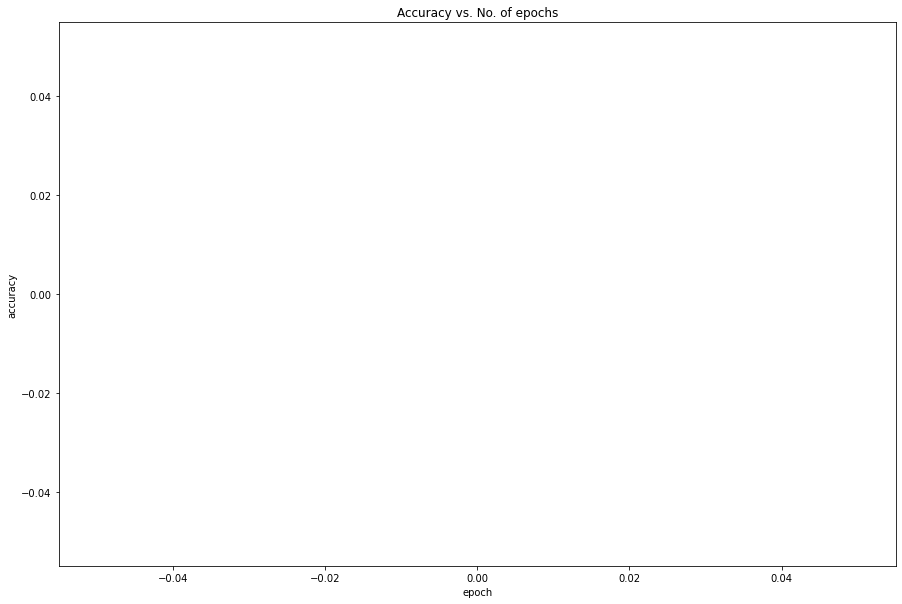

In [100]:
plot_accuracies(val_metrics)

In [101]:
def plot_losses(train_losses, val_losses):
    #train_losses = [x.get('train_losses') for x in history]
    #val_losses = [x['val_losses'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

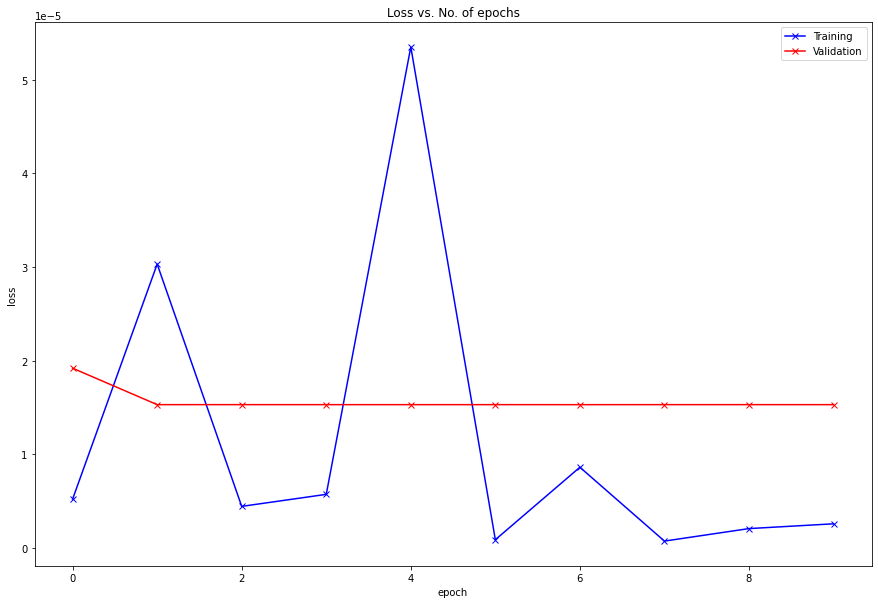

In [102]:
plot_losses(train_losses, val_losses)

In [103]:
result = evaluate(model, loss_fn, testLoader)
result

(8.237173748934115e-06, 182, None)

In [104]:
torch.save(model.state_dict(), 'csrnet.pth')

References:
    
1) https://github.com/gjy3035/Awesome-Crowd-Counting/blob/master/src/Datasets.md

2) 